In [102]:
from typing import Tuple

In [118]:
import torch
from torch_geometric.data import InMemoryDataset, Data, Batch
from torch.utils.data import DataLoader, Subset
from sklearn.calibration import LabelEncoder
import json 

In [119]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Constants

In [120]:
GENERATED_DATASET_SIZE = 300
BATCH_SIZE = 256
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2

In [121]:

def dict_to_geometric_representation(in_graph_dict: dict, encoder) -> Data:
    node_list = []
    edge_mappings = []
    def traverse_graph(graph = in_graph_dict):
        nonlocal node_list
        nonlocal edge_mappings
        curr_node_index = len(node_list)
        encoded_data = encoder({"type": graph["type"], "subtype": graph["subtype"], "value": graph["value"]})
        # print("Encoded data: ", encoded_data)
        node_list.append(encoded_data)
        if "children" in graph.keys():
            for child in graph["children"]:
                edge_mappings.append((curr_node_index, traverse_graph(child)) ) #I'm retarded.
        return curr_node_index
    traverse_graph()
    nodes = torch.tensor(node_list,dtype=torch.float32)
    if not torch.all(torch.isfinite(nodes)):
        print("NODES CONTAIN INFINITE VALUE ---> \n")
        print("X = ", nodes)
    nodes[nodes == float("Inf")] = 0
    if not torch.all(torch.isfinite(nodes)):
        print("CHECK #2 () NODES CONTAIN INFINITE VALUE ---> \n")
        print("X = ", nodes)
    edges = torch.tensor([[x[0] for x in edge_mappings], [x[1] for x in edge_mappings]], dtype=torch.long) # Probably slow and mentally degenerated
    geom_data = Data(x=nodes, edge_index=edges)
    return geom_data

In [122]:
TYPES = ["FUNC", "OPERATION", "POW", "LITERAL", "VARIABLE", "CONSTANT_LITERAL"]
OPERATIONS = ["ADD", "MUL", "FUNC", "POW"]
FUNCTIONS = ["SIN", "COS", "TAN", "EXP", "LOG", "SINH", "COSH"]
VARIABLE_ALPHABET = [chr(x) for x in range(ord('a'), ord('z')+1) if chr(x) not in ["e", "i"]]
CLASSIC_CONSTANTS = ["PI", "I", "g","e", "zoo"]


In [123]:

import math

nan_count = 0 
sample_count = 0
def make_node_attribute_encoder(label_encoder:LabelEncoder, rep = 4):
    def node_attr_encoder(attr):
        global nan_count
        global sample_count
        type_encoding = label_encoder.transform([attr["type"]]) if attr["type"] else [-1]
        subtype_encoding = label_encoder.transform([attr["subtype"]]) if attr["subtype"] else [-1]
        value_encoding_vec = None
        if attr["value"]:
            if isinstance(attr["value"], str):
                value_encoding = label_encoder.transform([attr["value"]])
                value_encoding_vec = [(0 if i % 2 == 0 else value_encoding[0]) for i in range(rep)]
            else: 
                # big num correction: 
                sample_count += 1
                val = float(attr["value"])
                    
                if math.isfinite(val) and (not math.isnan(val)):
                    value_encoding_vec = [(0 if i % 2 == 1 else val) for i in range(rep)]
                else:
                    print("val = ", val, " ; attr = ", attr["value"])
                    val = 0
                    nan_count += 1
                    value_encoding_vec = [(-1 if i % 2 == 1 else 1) for i in range(rep)]
                
        else:
            value_encoding = [-1]
            value_encoding_vec = value_encoding*rep 
        
        type_encoding_vec = [type_encoding[0]] * rep
        subtype_encoding_vec = [subtype_encoding[0]] * rep       
        
        return type_encoding_vec + subtype_encoding_vec + value_encoding_vec
        # if isinstance(attr, str) and attr in OPERATIONS+FUNCTIONS+CLASSIC_CONSTANTS+VARIABLE_ALPHABET:
        #     res = label_encoder.transform([attr])
        #     return [res[0]]*(rep + 1)
        # else:
        #     return [0] + [float(attr)]*rep
        
            
    return node_attr_encoder

In [124]:
def create_dataset_class(expression):
    # Will it be the same for both datasets ? 
    le = LabelEncoder()
    le.fit(OPERATIONS+FUNCTIONS+CLASSIC_CONSTANTS+VARIABLE_ALPHABET+TYPES)
    class MathExpressionDataset(InMemoryDataset):
        def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
            super().__init__(root, transform, pre_transform, pre_filter, force_reload=True)
            self.load(self.processed_paths[0])
            
        @property
        def raw_file_names(self):
            return ['math_datagen.json']

        @property
        def processed_file_names(self):
            return ['data.pt']
        

        def process(self):
            # Read data into huge `Data` list.
            data_list = []
            for file in self.raw_file_names:
                with open(file) as file_handle:
                    object_data = json.load(file_handle)
                    for comparison in object_data:
                        # print("Comparison before : ",comparison)
                        # LEGACY : Remove first case once fixed bug in datagen
                        if isinstance(comparison,list):
                            expr = comparison[0 if expression == "expr_l" else 1]
                            score = comparison[2]
                            geometric_expr = dict_to_geometric_representation(expr, make_node_attribute_encoder(le))
                            geometric_expr.y = score #torch.tensor([score],dtype=torch.float32)
                            data_list.append(geometric_expr)
                        else:
                            expr = comparison[expression]
                            score = comparison["score"]
                            geometric_expr = dict_to_geometric_representation(expr, make_node_attribute_encoder(le))
                            geometric_expr.y = score #torch.tensor([score],dtype=torch.float32)
                            data_list.append(geometric_expr)
                        
            if self.pre_filter is not None:
                data_list = [data for data in data_list if self.pre_filter(data)]

            if self.pre_transform is not None:
                data_list = [self.pre_transform(data) for data in data_list]
            self.save(data_list, self.processed_paths[0])
    return MathExpressionDataset
    

In [125]:
class ExpressionPairDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__()
        self.dataset_l = create_dataset_class("expr_l")(root+"_l",transform=None, pre_transform=None, pre_filter=None)
        self.dataset_r = create_dataset_class("expr_r")(root+"_r",transform=None, pre_transform=None, pre_filter=None)
        
    @property 
    def num_features(self):
        return self.dataset_l.num_features
    
    def __len__(self):
        return len(self.dataset_l)
        
    
    
    def __getitem__(self, idx):
        return self.dataset_l[idx], self.dataset_r[idx]

In [126]:
#generate_dataset(GENERATED_DATASET_SIZE,"math_datagen.json") #TODO: Switch to orjson, loading this file will take ages as I generate more data
dataset = ExpressionPairDataset(root="/math_dataset")

Processing...


NODES CONTAIN INFINITE VALUE ---> 

X =  tensor([[ 7.,  7.,  7.,  7., -1., -1., -1., -1., inf,  0., inf,  0.]])
val =  inf  ; attr =  inf
NODES CONTAIN INFINITE VALUE ---> 

X =  tensor([[10.0000, 10.0000, 10.0000, 10.0000,  9.0000,  9.0000,  9.0000,  9.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [ 7.0000,  7.0000,  7.0000,  7.0000, -1.0000, -1.0000, -1.0000, -1.0000,
             inf,  0.0000,     inf,  0.0000],
        [12.0000, 12.0000, 12.0000, 12.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [10.0000, 10.0000, 10.0000, 10.0000,  9.0000,  9.0000,  9.0000,  9.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [ 7.0000,  7.0000,  7.0000,  7.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000,  0.0000, -1.0000,  0.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          0.0000,  6.0000,  0.0000,  6.0000],
        [ 7.0000,  7.0000,  7.0000,  7.0000, -1.0000, -1.00

Done!
Processing...


NODES CONTAIN INFINITE VALUE ---> 

X =  tensor([[ 7.,  7.,  7.,  7., -1., -1., -1., -1., inf,  0., inf,  0.]])
NODES CONTAIN INFINITE VALUE ---> 

X =  tensor([[ 7.,  7.,  7.,  7., -1., -1., -1., -1., inf,  0., inf,  0.]])
NODES CONTAIN INFINITE VALUE ---> 

X =  tensor([[ 7.,  7.,  7.,  7., -1., -1., -1., -1., inf,  0., inf,  0.]])
val =  inf  ; attr =  inf
val =  inf  ; attr =  inf
val =  inf  ; attr =  inf
NODES CONTAIN INFINITE VALUE ---> 

X =  tensor([[10.0000, 10.0000, 10.0000, 10.0000,  9.0000,  9.0000,  9.0000,  9.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [ 7.0000,  7.0000,  7.0000,  7.0000, -1.0000, -1.0000, -1.0000, -1.0000,
             inf,  0.0000,     inf,  0.0000],
        [12.0000, 12.0000, 12.0000, 12.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [10.0000, 10.0000, 10.0000, 10.0000,  9.0000,  9.0000,  9.0000,  9.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [ 7.0000,  7.0000,  7.0000,  

Done!


In [127]:
print(len(dataset))

8000


In [128]:
print("nan_count", nan_count)
print("sample_count: ", sample_count)

nan_count 36
sample_count:  32484


In [158]:
from torch import nn
from torch.nn import Linear, ReLU, LeakyReLU, init
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler


In [159]:
class FormulaNet(nn.Module):
    def __init__(self, hidden_channels: int, embedding_space: int):
        super(FormulaNet, self).__init__()
        self.dense_1 = Linear(dataset.num_features, dataset.num_features*2) 
        self.dense_2 = Linear(dataset.num_features*2, dataset.num_features*2) 
        
        self.relu_1 = LeakyReLU(0.2)
        self.gconv_1 = GCNConv(dataset.num_features*2, hidden_channels)
        self.gconv_2 = GCNConv(hidden_channels, hidden_channels)
        self.dense_3 = Linear(hidden_channels, embedding_space)
        gain = torch.nn.init.calculate_gain("leaky_relu", 0.2)
        # Initialize dense_1 weights
        init.xavier_uniform_(self.dense_1.weight, gain=gain)
        init.xavier_uniform_(self.dense_2.weight, gain=gain)
        # # Initialize gconv_1 weights
        init.xavier_uniform_(self.gconv_1.lin.weight.data.T, gain=gain)
        # # Initialize gconv_2 weights
        init.xavier_uniform_(self.gconv_2.lin.weight.data.T, gain=gain)
        #Initialize dense_3 weights
        init.xavier_uniform_(self.dense_3.weight, gain=gain)
    
    def forward(self, x, edge_index, batch):
        if not torch.all(torch.isfinite(x)):
            print("INPUT CONTAINS INFINITE VALUE")
            #print("x = ", x)
            


        nan_mask = torch.isnan(x)
        if nan_mask.any():
            print("Some values of the input are nan: ", x[nan_mask])
            # Replace NaNs with 0s
            x[nan_mask] = -11
            
        
        # print("X = ", str(x))
        x = self.dense_1(x)
        # print("d1 X = ", str(x))
        x = self.relu_1(x)
        
        x = self.dense_2(x)
        x = self.relu_1(x)

        # #print("rd1 X = ", str(x))
        x = self.gconv_1(x, edge_index)
        # print("gcn1 X = ", str(x))
        x = self.relu_1(x)
        # print("rgcn1 X = ", str(x))
        # x = self.gconv_2(x, edge_index)
        # # print("gcn2 X = ", str(x))
        # x = self.relu_1(x)
        # # print("rgcn2 X = ", str(x))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.4,training=self.training)
        x = self.dense_3(x)
        x = self.relu_1(x)
        # nan_mask = torch.isnan(x)
        # if nan_mask.any():
        #     print("Some values of the input are nan: ", x[nan_mask])
            
        return x
    

In [160]:
class SiameseFormulaNet(nn.Module):
    def __init__(self, hidden_channels, embedding_space):
        super(SiameseFormulaNet, self).__init__()
        self.formulanet = FormulaNet(hidden_channels, embedding_space)
        # self.fc = nn.Sequential(
        #     Linear(embedding_space*2, embedding_space),
        #     ReLU(inplace=True),
        #     Linear(embedding_space, 1)
        # )
        # self.sigmoid = nn.Sigmoid() # TODO: Only used it for testing purposes, everything is subject to change Okay
    

    def forward(self, expr_l, expr_r):
        # print(expr_l)
        # print("X = ", expr_l.x)
        # print("X shape = ", expr_l.x.shape)
        # print("Batch = ",expr_l.batch)
        # print("Batch shape = ",expr_l.batch.shape)
        # print("Y =", expr_l.y)
        # print("Edge index = ",expr_l.edge_index)
        # print("Edge index shape = ",expr_l.edge_index.shape)
        
        embed_l = self.formulanet(expr_l.x,expr_l.edge_index, expr_l.batch)
        # print("Embed Left : ", embed_l)
        # print("Embed Left Shape: ", embed_l.shape)
        # embed_l = embed_l.view(embed_l.size()[0], -1)
        
        
        embed_r = self.formulanet(expr_r.x,expr_r.edge_index, expr_r.batch)
        # print("Embed Right : ", embed_r)
        # print("Embed Right Shape: ", embed_r.shape)
        # embed_r = embed_r.view(embed_r.size()[0], -1)
        
        # output = torch.cat((embed_l, embed_r), 1)
        
        # output = self.fc(output)
        # output = self.sigmoid(output)
        # return output
        return embed_l, embed_r
        
        
        

In [161]:
from torch.utils.data import random_split

In [162]:
total_len = len(dataset.dataset_l)
train_len = int(TRAIN_RATIO * total_len)
val_len = int(VAL_RATIO * total_len)
test_len = total_len - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

In [163]:

def collate(data_list):
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB
# NOTE: Type ignore only for collate_fn_t ... make sure it doesn't get in the way of correct typing for the dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate) # type: ignore
validation_laoder = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle= False, collate_fn = collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate) # type: ignore


In [164]:
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [165]:
model = SiameseFormulaNet(32,32).to(device)

In [166]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0000000005)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=0.0005, total_iters=10)

In [167]:
from tqdm import tqdm

In [168]:
training_loss = []  # Store training loss per epoch
validation_loss = []  # Store validation loss per epoch

In [169]:
def contrastive_loss(embed_l, embed_r, labels, margin=1.0, threshold=0.5):
    # print("Embed Left : ", embed_l)
    # print("Embed Left shape: ", embed_l.shape)
    # print("Embed Right : ", embed_r)
    # print("Embed Right shape: ", embed_r.shape)
    euclidean_distance = F.pairwise_distance(embed_l, embed_r)
    # print("Euclidean distance : ", euclidean_distance)
    #labels = (labels > threshold).float()  # Convert labels to 0 or 1
    # print("Labels : ", labels)
    # print("Labels : ", labels)
    loss_contrastive = torch.mean((1 - labels) * torch.pow(euclidean_distance, 2) +
                                  labels * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    
    # print("Constrastive Loss : ", loss_contrastive)
    return loss_contrastive

In [170]:
def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_l, batch_r in tqdm(train_loader, desc=f'Epoch {epoch}'):

        batch_l, batch_r = batch_l.to(device), batch_r.to(device)
        optimizer.zero_grad()
        embed_l, embed_r = model(batch_l, batch_r)
        loss = contrastive_loss(embed_l, embed_r, batch_l.y, margin=100.0)
        loss.backward()
        writer.add_scalar("Loss/train", loss, epoch)
        
        # Log gradients
        # for name, param in model.formulanet.named_parameters():
        #     if param.grad is not None and param.grad.numel() > 0:
        #         writer.add_histogram(f'{name}.grad', param.grad, epoch)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(epoch)
        epoch_loss += loss.item()
    training_loss.append(epoch_loss / len(train_loader))  # Store epoch average loss
    print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

In [171]:
def validate():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_l, batch_r in validation_laoder:
            batch_l, batch_r = batch_l.to(device), batch_r.to(device)
            embed_l, embed_r = model(batch_l, batch_r)
            # euclidean_distance = F.cosine_similarity(embed_l, embed_r)
            # pred = (euclidean_distance < 0.5).float()  # Adjust the threshold as needed
            # correct += (pred == batch_l.y).sum().item()
            test_loss += contrastive_loss(embed_l, embed_r, batch_l.y , margin=100.0).item()

    test_loss /= len(test_loader)
    # acc = correct / len(test_dataset)
    # validation_loss.append(acc)  # Store epoch average loss

    print(f'Test Loss: {test_loss}, Accuracy: ---')

In [172]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [173]:
torch.set_printoptions(threshold=100000)

In [174]:
num_epochs = 10

for epoch in range(num_epochs):
    train(epoch)
    validate()

Epoch 0: 100%|██████████| 19/19 [00:01<00:00, 17.74it/s]


Epoch 0, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 1: 100%|██████████| 19/19 [00:00<00:00, 30.19it/s]


Epoch 1, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 2: 100%|██████████| 19/19 [00:00<00:00, 28.92it/s]


Epoch 2, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 3: 100%|██████████| 19/19 [00:00<00:00, 30.72it/s]


Epoch 3, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 4: 100%|██████████| 19/19 [00:00<00:00, 24.32it/s]


Epoch 4, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 5: 100%|██████████| 19/19 [00:00<00:00, 31.71it/s]


Epoch 5, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 6: 100%|██████████| 19/19 [00:00<00:00, 31.20it/s]


Epoch 6, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 7: 100%|██████████| 19/19 [00:00<00:00, 29.53it/s]


Epoch 7, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 8: 100%|██████████| 19/19 [00:00<00:00, 28.09it/s]


Epoch 8, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 9: 100%|██████████| 19/19 [00:00<00:00, 24.64it/s]


Epoch 9, Loss: nan
Test Loss: nan, Accuracy: ---


In [ ]:
writer.close()

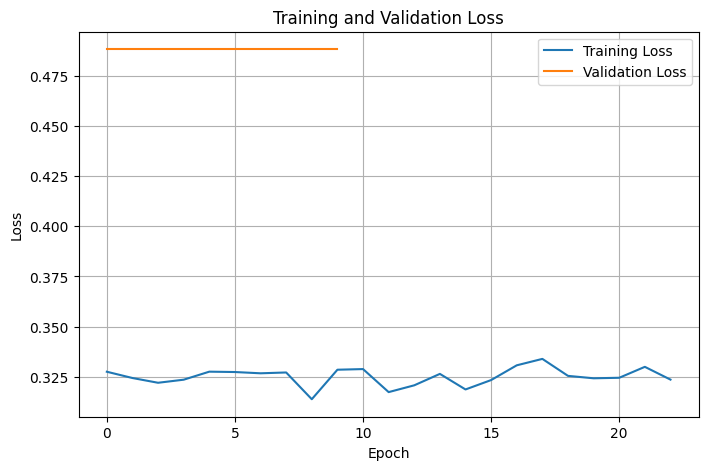

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.show()


## Evaluation

In [76]:
le = LabelEncoder()
le.fit(OPERATIONS+FUNCTIONS+CLASSIC_CONSTANTS+VARIABLE_ALPHABET+TYPES)
eval_node_attr_encoder = make_node_attribute_encoder(le)

In [77]:
expr_left = {
      "type": "POW",
      "value": None,
      "subtype": None,
      "children": [
        {
          "type": "POW",
          "value": None,
          "subtype": None,
          "children": [
            {
              "type": "LITERAL",
              "value": -3.5,
              "subtype": None,
              "children": []
            },
            {
              "type": "LITERAL",
              "value": 3.0,
              "subtype": None,
              "children": []
            }
          ]
        },
        {
          "type": "LITERAL",
          "value": 4.5,
          "subtype": None,
          "children": []
        }
      ]
    }
expr_right = {
      "type": "POW",
      "value": None,
      "subtype": None,
      "children": [
        {
          "type": "OPERATION",
          "value": None,
          "subtype": "ADD",
          "children": [
            {
              "type": "LITERAL",
              "value": -5.5,
              "subtype": None,
              "children": []
            },
            {
              "type": "LITERAL",
              "value": -10.0,
              "subtype": None,
              "children": []
            }
          ]
        },
        {
          "type": "LITERAL",
          "value": 4.0,
          "subtype": None,
          "children": []
        }
      ]
    }

expr_right_constant_error = {
      "type": "POW",
      "value": None,
      "subtype": None,
      "children": [
        {
          "type": "POW",
          "value": None,
          "subtype": None,
          "children": [
            {
              "type": "LITERAL",
              "value": -5.9,
              "subtype": None,
              "children": []
            },
            {
              "type": "LITERAL",
              "value": -10.0,
              "subtype": None,
              "children": []
            }
          ]
        },
        {
          "type": "LITERAL",
          "value": 4.0,
          "subtype": None,
          "children": []
        }
      ]
    }

In [78]:
expr_l_obj = dict_to_geometric_representation(expr_left, eval_node_attr_encoder)
expr_r_obj = dict_to_geometric_representation(expr_right, eval_node_attr_encoder)
expr_r_c_obj = dict_to_geometric_representation(expr_right_constant_error, eval_node_attr_encoder)

-3.5
3.0
4.5
-5.5
-10.0
4.0
-5.9
-10.0
4.0


In [79]:
y_1 = model(expr_l_obj, expr_r_obj)
y_2 = model(expr_l_obj, expr_l_obj)
y_3 = model(expr_r_obj, expr_r_obj)
y_4 = model(expr_r_obj, expr_r_c_obj)

In [80]:
print(F.cosine_similarity(y_1[0], y_1[1]))
print(F.cosine_similarity(y_2[0], y_2[1]))
print(F.cosine_similarity(y_3[0], y_3[1]))
print(F.cosine_similarity(y_4[0], y_4[1]))


tensor([0.9998], grad_fn=<SumBackward1>)
tensor([1.0000], grad_fn=<SumBackward1>)
tensor([1.], grad_fn=<SumBackward1>)
tensor([1.0000], grad_fn=<SumBackward1>)


In [71]:
# from torchviz import make_dot

# Misc

In [224]:
# make_dot(y_f.mean(), params=dict(formulanet.named_parameters()))